# Optimization for Data Science 2024 Homework 1

**Students:**

*Alberto Calabrese* - Student ID: 2103405

*Greta d'Amore Grelli* - Student ID: 2122424

*Eleonora Mesaglio* - Student ID: 2103402

*Marlon Helbing* - Student ID: 2106578

## 1. Generating the dataset

## Cost function 

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Set a seed for deterministic outputs
SEED = 42
np.random.seed(seed = SEED)

In [160]:
NUM_SAMPLES = 1000
NUM_FEATURES = 1000
NUM_LABELS = 50
NUM_EXAMPLES = 1000

# A MATRIX
# Generate a 1000x1000 matrix with random samples from a standard normal distribution
# This is our data matrix, which contains 1000 samples (rows) with 1000 features each (columns)
data_matrix = np.random.normal(0, 1, size = (NUM_SAMPLES, NUM_FEATURES))
A = data_matrix 
# 'A' contains random values drawn from N(0,1)
print("A shape: ", A.shape)

# X MATRIX
# This is our weight matrix that we initialize like this ; these weights we want to learn
# it has 1000 features (rows) with 50 labels each (columns)
weight_matrix = np.random.normal(0, 1, size = (NUM_FEATURES, NUM_LABELS))
X = weight_matrix
# 'X' contains random values drawn from N(0,1)
print("X shape: ", X.shape)

# E MATRIX
# This matrix is used to help generating our supervised gold labels 
# It is of size 1000 training examples (rows) and their labels (columns)
generative_matrix = np.random.normal(0, 1, size = (NUM_EXAMPLES, NUM_LABELS))
E = generative_matrix
# 'E' contains random values drawn from N(0,1)
print("E shape: ", E.shape)

# LABEL VECTOR
# Create a vector with numbers from 1 to 50
label_vector = np.arange(1, 51)

# Now calculate AX+E to generate labels for the 1000 training examples (such that we have a supervised learning set) 

result_matrix = A @ X + E

print("AX+E shape: ", result_matrix.shape)

A shape:  (1000, 1000)
X shape:  (1000, 50)
E shape:  (1000, 50)
AX+E shape:  (1000, 50)


## 2. MAX INDEX AS CLASS LABEL

In [161]:
# We find our labels by considering the max index in the row as the class label
# Find the column indices of maximum values for each row
labels = np.argmax(result_matrix, axis=1)
print("Labels shape: ", labels.shape)

# 'labels' now contains the column indices of maximum values for each row

Labels shape:  (1000,)


In [162]:
m = NUM_SAMPLES # samples
d = NUM_FEATURES # features
k = NUM_LABELS   # labels

## 3. Cost function 

In [163]:
def cost_function(X,A,labels):
    # This function is ugly but just for testing if we did smth wrong
    sum_1 = 0
  
    for sample_idx in range(m):

        # Take the column at index of the label of the current sample
        x_bi = X[:, labels[sample_idx]]
        x_bi = -1 * x_bi
        a_i = A[sample_idx, :]
        sum_1 += (x_bi @ a_i) # automatically calculates (1,1000) x (1000,1)
    sum_2 = 0
    for sample_idx in range(m):
        current = 0 # so we have the correct start value
        for label_idx in range(k):
            current += np.exp((X[:,label_idx]) @ A[sample_idx,:])
        sum_2 += np.log(current)

    return sum_1 + sum_2

## 4.Partial Gradient
We define as a block a single column in the parameter matrix $X$. Thus, one block defines all features for a single class. As this is a column vector in the matrix $X$, our partial gradient is now only dependent on $c$.

Then, our partial derivatives with respect with one block have the following form

\begin{equation}
\frac{\partial f(X)}{\partial X_{c}} = - A^{T} \cdot (I_c - Q_c) = A^{T} \cdot (- I_c + Q_c)
\end{equation}


where 

$A$ has shape $m \times d$, it is our given matrix A;
\
$I_c$ has shape $m \times 1$, it is the indicator vector containing $1$'s only at the positions where the label of the current sample $i$ is $c$ and $0$'s everywhere else;
$$
I_c=\begin{cases}
			1 \quad & \text{if $label_{i} = c $}\\
            0 \quad & \text{otherwise}
		 \end{cases}
$$
\
$Q_c$ has shape $m \times 1$, it is the vector calculating the exponential expression $\dfrac{\exp(x_{c}^{T}a_{i})}{\sum_{c' = 1}^{k} \exp(x_{c'}^{T}a_{i}) }$ for each sample $i$.

Thus, our result will be of form $d \times 1$.

Note that the calculations needed for $I_c$ and $Q_c$ only depend on $c$ and $i$. However, as we know all the samples $i$, we construct the vectors $I_c$ and $Q_c$ which are then only dependent on $c$.

In [164]:
def partial_gradient(X,A,labels,c):
    # We need X as parameter so it changes value across diff gradients

    # We define the partial gradient
    
    # Calculating indicator vector L 

    # Initialize empty L in size of all samples (=1000)
    L = np.zeros((m,1))

    # Iterate over labels of each sample
    for idx,label in enumerate(labels):
        # If there is a label match
        if label == c:
            # We assign a 1
            L[idx] = 1
        # If there is no match
        else:
            # We assign a 0
            L[idx] = 0

    # Calculating vector Q
    # Initialize empty Q in size of all samples (=1000)
    
    Q = np.zeros((m,1))

    # Iterate over all samples
    for curr_sample in range(m):
    
        nominator = np.exp((X[:,c]) @ (A[curr_sample,:]))
    
        denominator = 0
        # Iterate over all labels for the denominator
        for curr_label in range(k):
            denominator += np.exp((X[:,curr_label]) @ A[curr_sample,:])
    
        Q[curr_sample] = nominator/denominator

    return (np.dot(A.T, ((-1 * L) + Q))).squeeze() # returns (1000,)

## 5. Full gradient

In [165]:
def full_gradient(X,A,labels):
    # initialize zero gradient of size (d,)
    grad = np.zeros(d)
    for label in range(k):
        grad = np.column_stack((grad, partial_gradient(X,A,labels,label)))

    return grad[:,1:] #remove 0 column

## 6. Gradient Descent Algorithm

In [166]:
def gradient_descent(X,A,labels,lr, iterations = 20):
    X_0 = X
    gradient_norms = []
    for i in range(iterations): # number of iterations
        print(f'Loss at iteration {i} (GD): {cost_function(X_0, A,labels)}')

        # Gradient step

        # Calculate current gradient
        gradient_at_i = full_gradient(X_0,A,labels)
        # Calculate the norm
        gradient_norms.append(np.linalg.norm(gradient_at_i))
        # Gradient step
        X_0 = X_0 - lr * gradient_at_i

    # Create an array of iteration numbers
    iterations = np.arange(len(gradient_norms))

    # Create Gradient Norm Plot
    plt.figure(figsize=(10, 6))
    plt.plot(iterations, gradient_norms, label='Gradient Norm')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norm across Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

Loss at iteration 0 (GD): 93.39358249527868


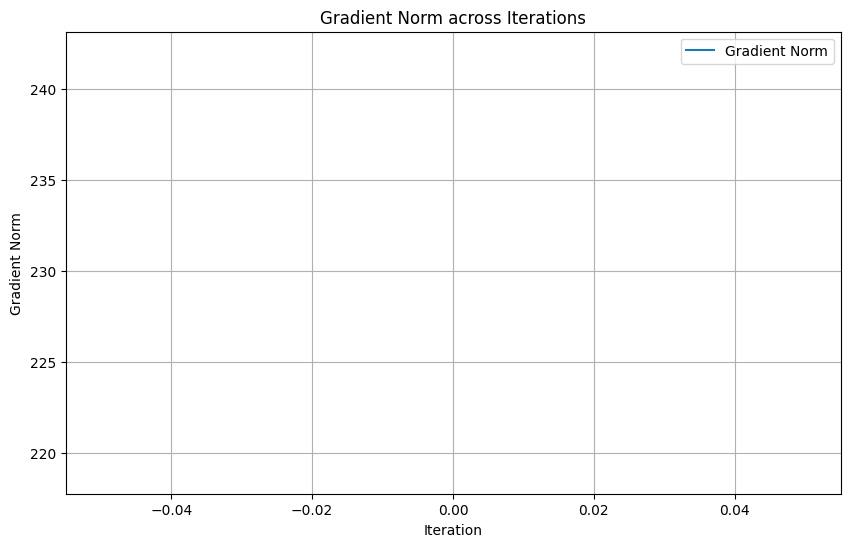

In [167]:
gradient_descent(X,A,labels, lr= 0.001,  iterations=1)




## 7. BCGD Randomized Rule

In [168]:
def BCGD_randomized(X,A,labels, iterations = 500):

    X_0 = X
    for i in range(iterations): 
        curr_c = random.randint(0,k-1)
        print("Current Loss : {}".format(cost_function(X_0, A, labels)))
        # Gradient step
        X_0[:, curr_c] = X_0[:, curr_c] - 0.001 * partial_gradient(X_0,A,labels,curr_c) 

In [169]:
BCGD_randomized(X,A,labels, iterations=20)

Current Loss : 93.39358249527868
Current Loss : 93.1551439503819
Current Loss : 91.75785232694761
Current Loss : 90.83025853786967
Current Loss : 90.3484454300924
Current Loss : 89.07651126453129
Current Loss : 88.35319848399376
Current Loss : 87.44028136588167
Current Loss : 86.50551504001487
Current Loss : 85.99811663661967
Current Loss : 84.5143983419839
Current Loss : 83.55935294870869
Current Loss : 83.51733101750142
Current Loss : 82.98011271347059
Current Loss : 82.5558651483152
Current Loss : 81.54091778010479
Current Loss : 80.9637788352702
Current Loss : 80.1990670995583
Current Loss : 78.83016910076549
Current Loss : 78.24544444480853


## 8. BCGD Gauss-Southwell Algorithm

In [170]:
# We have to calculate the partial gradient of each block
# We calculate it in our partial_gradient function.
# Thus, we have to iterate over all possible blocks , which in our case are class - many, so k many 

def Gauss_Southwell(X,A, labels, iterations=20):

    learning_rate = 0.01 # TODO : REPLACE BY LIPSCHITZ
    X_0 = X
    for it in range(iterations): # iterations
        
        all_partial_gradients = []
        for label_idx in range(k): # k is number of all labels
            # Calculate the partial gradient of each block
            all_partial_gradients.append(partial_gradient(X_0,A,labels,label_idx))

        # Gradients will be of size (features,) so in our case (1000,) 
        all_partial_gradients_norms = [np.linalg.norm(curr_grad) for curr_grad in all_partial_gradients]

        max_idx = np.argmax(all_partial_gradients_norms)
   
        partial_grad = all_partial_gradients[max_idx]

        # Gradient Descent 
        print(f'Loss at iteration {it} (BCGD G.S.): {cost_function(X_0, A,labels)}')
        # Gradient step
        X_0[:, max_idx] = X_0[:, max_idx] - learning_rate * partial_grad

In [171]:
# Lest's see how it performs
Gauss_Southwell(X,A,labels,iterations=20)

Loss at iteration 0 (BCGD G.S.): 77.4546820892574


## 9. Real Dataset

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 

Modeling wine preferences by data mining from physicochemical properties.

In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

Available at: [@Elsevier] http://dx.doi.org/10.1016/j.dss.2009.05.016
            [Pre-press (pdf)] http://www3.dsi.uminho.pt/pcortez/winequality09.pdf
            [bib] http://www3.dsi.uminho.pt/pcortez/dss09.bib

1. Title: Wine Quality 

2. Sources
   
   Created by: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009

 
3. Relevant Information:

   The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine.
   For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].
   Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables 
   are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

   These datasets can be viewed as classification or regression tasks.
   The classes are ordered and not balanced (e.g. there are munch more normal wines than
   excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent
   or poor wines. Also, we are not sure if all input variables are relevant. So
   it could be interesting to test feature selection methods. 

4. Number of Instances: red wine - 1599; white wine - 4898. 

5. Number of Attributes: 11 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of feature selection.

6. Attribute information:

   Input variables (based on physicochemical tests):

      1 - fixed acidity
      
      2 - volatile acidity
      
      3 - citric acid
      
      4 - residual sugar
      
      5 - chlorides
      
      6 - free sulfur dioxide
      
      7 - total sulfur dioxide
      
      8 - density
      
      9 - pH
      
      10 - sulphates
      
      11 - alcohol
   
   Output variable (based on sensory data): 
   
      12 - quality (score between 0 and 10)



## Import, Exploration and Preparation

In [ ]:
from sklearn.preprocessing import StandardScaler
# Adjust the path to the location of the dataset on your machine -----------------
data_red_wine = pd.read_csv('/Users/marlon/VS-Code-Projects/OptimizationNEW/HW1/wine+quality/winequality-red.csv', sep=';')
data_white_wine = pd.read_csv('/Users/marlon/VS-Code-Projects/OptimizationNEW/HW1/wine+quality/winequality-white.csv', sep=';')

# Let us define the labels from the dataset
labels_red = np.array(data_red_wine['quality'])
labels_white = np.array(data_red_wine['quality'])

# Let us see how many unique labels we have in both datasets
number_labels_red = np.unique(labels_red)
number_labels_white = np.unique(labels_white)

# Print the number of unique labels
print(number_labels_red)
print(number_labels_white)

# In both we only have labels from 3 to 8 (6 classes)

# Let us work on the red wine dataset


labels = np.array(data_red_wine['quality'])

# Set labels so they start from 0 , since our smallest label is 3 and they go up in 1-steps , just subtract 3
labels = labels - 3

# Drop the quality column
data_red_wine.drop('quality', axis=1, inplace=True)

# Scale the data
scaler = StandardScaler()
# Fit and transform the data
data_red_wine = pd.DataFrame(scaler.fit_transform(data_red_wine), columns=data_red_wine.columns)

# Convert the data to a numpy array
A = np.array(data_red_wine)

NUM_SAMPLES = data_red_wine.shape[0]
NUM_FEATURES = data_red_wine.shape[1]
NUM_LABELS = len(number_labels_red)

m = NUM_SAMPLES # samples
d = NUM_FEATURES # features
k = NUM_LABELS   # labels



[3 4 5 6 7 8]
[3 4 5 6 7 8]


## Train/Test Split


In [ ]:
from sklearn.model_selection import train_test_split

A_train, A_test, label_train, label_test = train_test_split(A, labels, test_size=0.2, random_state=42)

A_train.shape
label_train.shape

(1279,)

## Initiate Weight Matrix

In [ ]:
weight_matrix = np.random.normal(0, 1, size = (NUM_FEATURES, NUM_LABELS))
X = weight_matrix

print(X.shape)

(11, 6)


# GD

In [ ]:
m = A_train.shape[0] # set m to training examples , need to put m as param into function
#gradient_descent(X,A_train, label_train,lr = 0.0025, iterations=100)
BCGD_randomized(X,A_train, label_train, iterations=1000)


1279
Current Loss : 2053.9586771960003
1279
Current Loss : 2050.9296191687213
1279
Current Loss : 2046.8469388858857
1279
Current Loss : 2043.2985785254198
1279
Current Loss : 2041.0989213486255
1279
Current Loss : 2034.3520097606556
1279
Current Loss : 2032.6089685740878
1279
Current Loss : 2029.7079038834381
1279
Current Loss : 2028.208026414594
1279
Current Loss : 2024.8426015955008
1279
Current Loss : 2014.9247899027116
1279
Current Loss : 2012.548137564283
1279
Current Loss : 2011.3417801483918
1279
Current Loss : 2005.7427338143646
1279
Current Loss : 2001.1291731172792
1279
Current Loss : 1998.9376437168278
1279
Current Loss : 1997.8934694437628
1279
Current Loss : 1993.9751422487795
1279
Current Loss : 1993.0815260026195
1279
Current Loss : 1986.4335915064803
1279
Current Loss : 1981.4863958613414
1279
Current Loss : 1980.8004202710933
1279
Current Loss : 1979.0030554584173
1279
Current Loss : 1978.3698543462904
1279
Current Loss : 1975.1490500844843
1279
Current Loss : 1973.54